![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4210_Analisis_con_Deep_Learning/blob/master/lab_3/practica_7/practica_7.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>

## **Práctica 7**

## **Detección de Objectos**

## **Objetivos**
- Aprender a detectar objetos en contextos multi-etiqueta.
- Cargar Yolo en su versión 3 desde ceros.

## **Problema**
- En imágenes de varios contextos queremos detectar y clasificar todos los objetos posibles con 20 categorías disponibles.

In [1]:
"""
@article{
    yolov3,
    title={YOLOv3: An Incremental Improvement},
    author={Redmon, Joseph and Farhadi, Ali},
    journal = {arXiv},
    year={2018}
}
"""
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!git clone https://github.com/jpcano1/keras-yolo3.git
%cd "keras-yolo3"
import setup_colab_general as setup_general
setup_general.setup_general()

shred: setup_colab_general.py: failed to open for writing: No such file or directory
Cloning into 'keras-yolo3'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 170 (delta 11), reused 19 (delta 7), pack-reused 144
Receiving objects: 100% (170/170), 161.79 KiB | 2.84 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/keras-yolo3


  0%|          | 0/3 [00:00<?, ?KB/s]

General Functions Enabled Successfully


## **Importando las librerías necesarias para el laboratorio**

In [2]:
import numpy as np
import pandas as pd

import os
from glob import glob

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

import zipfile
import tarfile

from utils import general as gen

from tqdm.auto import tqdm

import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

from skimage import io
import cv2

import configparser

import xml.etree.ElementTree as ET

from yolo3.model import yolo_loss, preprocess_true_boxes, yolo_eval
from train import data_generator_wrapper
from yolo3.utils import get_random_data

from typing import List, Optional, Union, Any, Tuple

In [3]:
weights_id = "1cQjMbVN74EeFy1NNtUN73E8mgU-rN4ZS"
config_url = "https://raw.githubusercontent.com/pjreddie"\
             "/darknet/master/cfg/yolov3-tiny.cfg"

In [4]:
gen.download_file_from_google_drive(weights_id, "weights.h5", "models")
gen.download_content(config_url, "yolov3-tiny.cfg", "cfg")

0KB [00:00, ?KB/s]

  0%|          | 0/1 [00:00<?, ?KB/s]

## **Lectura, Visualización y Procesamiento**

In [5]:
voc = tfds.object_detection.Voc(data_dir="data")
voc.download_and_prepare(download_dir="data")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/voc/2007/4.0.0.incompleteQF96EF/voc-test.tfrecord


  0%|          | 0/4952 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/voc/2007/4.0.0.incompleteQF96EF/voc-train.tfrecord


  0%|          | 0/2501 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to data/voc/2007/4.0.0.incompleteQF96EF/voc-validation.tfrecord


  0%|          | 0/2510 [00:00<?, ? examples/s]

Dataset voc downloaded and prepared to data/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [31]:
annotations = sorted(glob("data/*/*/*/*/*/*.xml"))
images = sorted(glob("data/*/*/*/*/*/*.jpg"))
with open("data/voc/2007/4.0.0/labels.labels.txt") as f:
    classes = [class_.replace("\n", "") for class_ in f.readlines()]

colors = [
    (
        np.random.randint(0, 255), 
        np.random.randint(0, 255), 
        np.random.randint(0, 255),
    ) for _ in range(len(classes))
]

In [13]:
files_ = np.array(list(zip(images, annotations)))

full_train, test = train_test_split(files_, test_size=0.2, random_state=1234)
train, val = train_test_split(full_train, test_size=0.2, random_state=1234)

In [14]:
def convert_annotation(
    xml_input: str, 
    out_file,
):
    with open(xml_input, "r") as in_file:
        tree = ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter("object"):
            cls_ = obj.find("name").text
            if cls_ not in classes:
                continue
            cls_id = classes.index(cls_)
            bbox = obj.find("bndbox")
            bbox = (
                int(bbox.find("xmin").text), 
                int(bbox.find("ymin").text), 
                int(bbox.find("xmax").text),
                int(bbox.find("ymax").text),
            )
            out_file.write(
                " " + ",".join(
                    [str(coord) for coord in bbox]
                ) + "," + str(cls_id)
            )

In [15]:
def convert_to_out_file(
    collection: List[str], 
    out_file_path: str,
):
    with open(f"data/{out_file_path}", "w") as out_file:
        for img_file, label_file in tqdm(collection):
            img_id = img_file.split(os.path.sep)[-1].split(".")[0]
            out_file.write(img_file)
            convert_annotation(label_file, out_file)
            out_file.write("\n")

In [16]:
convert_to_out_file(train, "train.txt")

  0%|          | 0/6376 [00:00<?, ?it/s]

In [17]:
convert_to_out_file(val, "val.txt")

  0%|          | 0/1594 [00:00<?, ?it/s]

In [18]:
convert_to_out_file(test, "test.txt")

  0%|          | 0/1993 [00:00<?, ?it/s]

In [19]:
with open("data/train.txt", "r") as f:
    train_lines = f.readlines()

In [29]:
imgs = []
bbox_labels = {}
for idx in range(9):
    random_index = np.random.randint(0, len(train_lines))
    
    line = train_lines[random_index].replace("\n", "").split(" ")
    imgs.append(io.imread(line[0]))
    bbox_label_list = []
    for bbox_label in line[1:]:
        bbox_label_list.append(
            [int(number) for number in bbox_label.split(",")]
        )
    bbox_labels[idx] = bbox_label_list

In [39]:
labeled_imgs = []
for idx, img in enumerate(imgs):
    new_img = img.copy()

    for bbox_label in bbox_labels[idx]:
        new_img = cv2.rectangle(
            new_img,
            (bbox_label[0], bbox_label[1]),
            (bbox_label[2], bbox_label[3]),
            colors[bbox_label[4]], 8
        )
    labeled_imgs.append(new_img)

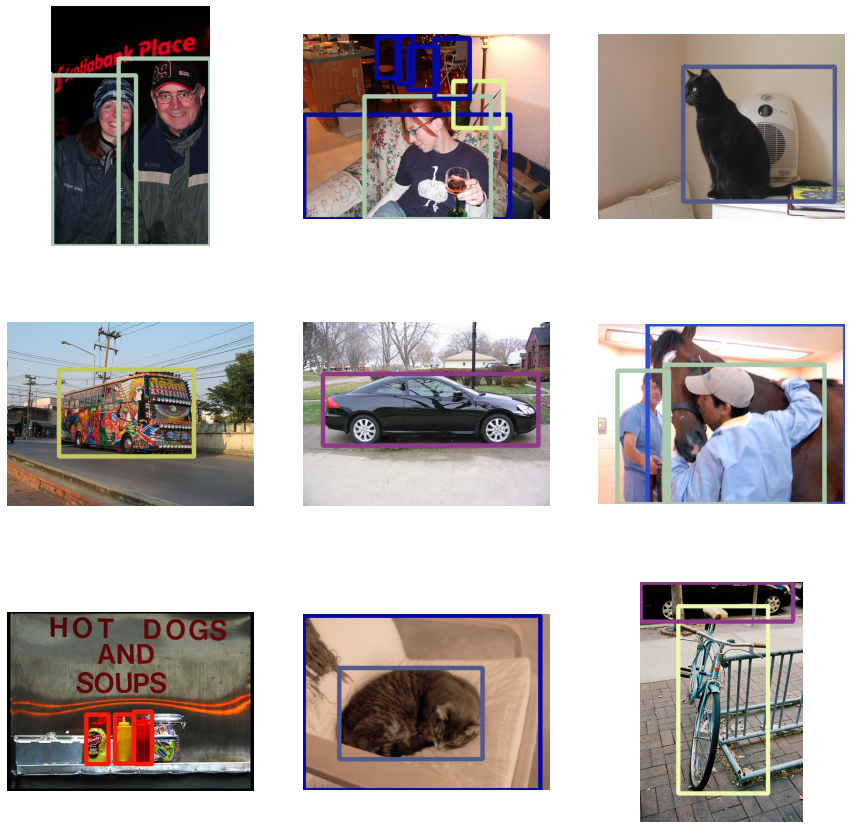

In [41]:
gen.visualize_subplot(
    labeled_imgs, [""] * 9, 
    (3, 3), (15, 15),
)

## **Model**
- En esta ocasión utilizaremos Yolo en su versión 3. Yolo resulta ser el mejor modelo para detección de objetos múltiples. Algunas de sus variaciones, aunque más simples, no llegan a ser tan efectivas como esta. 
- Otras arquitecturas basadas en Yolo son los Single-Shot Detectors (SSD) y las Region-Based CNN (R-CNN).

In [42]:
anchors = [10, 14, 23, 27, 37, 58, 81, 82, 135, 169, 344, 319]
anchors = np.array(anchors).reshape(-1, 2)

In [43]:
input_shape = (416, 416)

In [44]:
def get_model_from_config(
    config_file: str, 
    input_layer=keras.Input(shape=(None, None, 3)),
    num_anchors: int = 3, 
    num_classes: int = 20,
) -> keras.Model:
    """
    Function to obtain model architecture from config file
    :param config_file: the path of the config file
    :type config_file: str
    :param input_layer: The input layer
    :type input_layer: KerasTensor
    :param num_anchors: The number of anchors associated to 
    the architecture
    :type num_anchors: int
    :param num_classes: The number of classes of the dataset
    :type num_classes: int
    :return: The model built from config file
    :rtype: keras.Model
    """
    class multidict(dict):
        _counter = {}
        def __setitem__(self, key, val):
            if isinstance(val, dict):
                if key in self._counter:
                    self._counter[key] += 1
                else:
                    self._counter[key] = 1

                key += f"_{self._counter[key]}"
            dict.__setitem__(self, key, val)

    config = configparser.ConfigParser(
        defaults=None, 
        strict=False, 
        dict_type=multidict
    )

    config.read(config_file)

    last_layer = input_layer
    all_layers = []

    weight_decay = 0.0005

    out_index = []

    for section in config.sections():
        if section.startswith("net"):
            continue
        if section.startswith("convolutional"):
            filters = int(config.get(section, option="filters"))
            size = int(config.get(section, option="size"))
            stride = int(config.get(section, option="stride"))
            pad = bool(int(config.get(section, option="pad")))
            activation = config.get(section, option="activation")
            try:
                config.get(section, option="batch_normalize")
                batch_normalize = True
            except configparser.NoOptionError:
                batch_normalize = False

            padding = "same" if pad and stride == 1 else "valid"

            if stride > 1:
                last_layer = keras.layers.ZeroPadding2D(
                    padding=((1, 0), (1, 0))
                )(last_layer)

            activation = None
            if activation == "leaky":
                activation = "leaky_relu"

            if filters == 255:
                filters = num_anchors * (num_classes + 5)
            conv_layer = keras.layers.Conv2D(
                filters=filters,
                kernel_size=size,
                strides=stride,
                kernel_regularizer=keras.regularizers.l2(weight_decay),
                use_bias=not batch_normalize,
                padding=padding,
                activation=activation,
                name=section,
            )(last_layer)

            if batch_normalize:
                conv_layer = keras.layers.BatchNormalization()(conv_layer)

            last_layer = conv_layer

        elif section.startswith("route"):
            layer_ids = [
                int(idx) 
                for idx in config.get(
                    section, option="layers"
                ).split(",")
            ]
            route_layers = [all_layers[id_] for id_ in layer_ids]

            if len(route_layers) > 1:
                last_layer = keras.layers.Concatenate()(route_layers)
            else:
                last_layer = route_layers[0]
        elif section.startswith("maxpool"):
            size = int(config.get(section, option="size"))
            stride = int(config.get(section, option="stride"))
            last_layer = keras.layers.MaxPool2D(
                pool_size=size,
                strides=stride,
                padding="same",
                name=section,
            )(last_layer)

        elif section.startswith("shortcut"):
            index = int(config.get(section, option="from"))
            activation = config.get(section, option="activation")

            last_layer = keras.layers.Add()(
                [all_layers[index], last_layer]
            )

        elif section.startswith("upsample"):
            stride = int(config.get(section, option="stride"))
            last_layer = keras.layers.UpSampling2D(
                stride, name=section
            )(last_layer)
        
        elif section.startswith("yolo"):
            out_index.append(len(all_layers) - 1)
            last_layer = None

        all_layers.append(last_layer)

    if len(out_index) == 0:
        out_index.append(len(all_layers) - 1)

    return keras.Model(
        inputs=input_layer, 
        outputs=[all_layers[idx] for idx in out_index]
    )

def create_tiny_model(
    input_shape: Tuple[int], anchors: List[int], 
    num_classes: int, 
    weights_dir: str = "models/weights.h5",
) -> keras.Model:
    """
    Function to build and compile model
    :param input_shape: The input shape of the model
    :type input_shape: Tuple[int]
    :param anchors: The anchors of the net
    :type anchors List[int]
    :param num_classes: The number of the classes of the dataset
    :type num_classes: int
    :param weights_dir: The dir path of the weights file
    :type weights_dir: str
    :return: Model built and compiled
    :rtype: keras.Model
    """
    image_input = keras.Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)
    
    sizes = [32, 16]
    y_true = [
        keras.Input(
            shape=(
                h // b_size, w // b_size, 
                num_anchors // 2, 
                num_classes + 5,
            ),
        ) for b_size in sizes
    ]

    model_body = get_model_from_config(
        "cfg/yolov3-tiny.cfg",
        image_input, num_anchors // 2, 
        num_classes
    )

    model_body.load_weights(
        "models/weights.h5", 
        skip_mismatch=True, 
        by_name=True
    )

    model_loss = keras.layers.Lambda(
        yolo_loss, output_shape=(1, 0), name="yolo_loss",
        arguments={
            "anchors": anchors,
            "num_classes": num_classes,
            "ignore_thresh": .7,
        }
    )([*model_body.output, *y_true])

    model = keras.Model([model_body.input, *y_true], model_loss)

    return model

In [45]:
model = create_tiny_model(input_shape, anchors, 20)

In [46]:
def main(model):
    log_dir = 'logs/000/'
    num_classes = len(classes)
    train_path = "data/train.txt"
    val_path = "data/val.txt"

    input_shape = (416, 416) # multiple of 32

    logging = keras.callbacks.TensorBoard(log_dir=log_dir)
    checkpoint = keras.callbacks.ModelCheckpoint(
        log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, 
        save_best_only=True, period=3
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=3, 
        verbose=1
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=10, 
        verbose=1
    )

    with open(train_path) as f:
        train_lines = f.readlines()

    with open(val_path) as f:
        val_lines = f.readlines()

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-4), 
        loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        }
    )

    print("Data loaded")

    batch_size = 32
    model.fit_generator(
        data_generator_wrapper(
            train_lines, batch_size, 
            input_shape, anchors, num_classes,
        ),
        steps_per_epoch=len(train_lines) // batch_size,
        validation_data=data_generator_wrapper(
            val_lines, batch_size, 
            input_shape, anchors, num_classes,
        ),
        validation_steps=len(val_lines) // batch_size,
        epochs=50,
        callbacks=[
            logging, checkpoint, 
            reduce_lr, early_stopping
        ]
    )
    model.save_weights(log_dir + 'trained_weights_final.h5')

In [ ]:
main(model)

# **Validación y Predicción**

In [51]:
with open("data/test.txt") as f:
    test_lines = f.readlines()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    loss={
        'yolo_loss': lambda y_true, y_pred: y_pred
    }
)

In [ ]:
model.evaluate(
    data_generator_wrapper(
        test_lines, 32, 
        (416, 416), 
        anchors, 20, 
    ),
    steps=len(test_lines) // 32,
)

62/62 [==============================] - 141s 2s/step - loss: 39.6607


39.660736083984375

In [47]:
model = get_model_from_config(
    "cfg/yolov3-tiny.cfg",
    input_layer=keras.Input(shape=(*input_shape, 3))
)
model.load_weights("models/weights.h5")

In [48]:
def load_image_batch(dataset_lines: List[str]):
    img_batch = np.zeros((9, *input_shape, 3))
    for idx in range(9):
        index = np.random.randint(0, len(dataset_lines))
        img_path = dataset_lines[index].split()[0]
        img = io.imread(img_path).astype("float32")
        img /= 255.
        img_resized = cv2.resize(img, input_shape, cv2.INTER_LINEAR)
        img_batch[idx] = img_resized
    return img_batch

In [52]:
img_batch = load_image_batch(test_lines)

In [53]:
results = model(img_batch[0][np.newaxis, ...])

In [54]:
boxes_, scores_, classes_ = yolo_eval(
    results, anchors, 20, (416, 416), 
    score_threshold=0.005, iou_threshold=0.005,
)

In [56]:
new_img = img_batch[0].copy()

for box in boxes_:
    new_img = cv2.rectangle(
        new_img, 
        (box[0], box[1]),
        (box[0] + box[2], box[1] + box[3]),
        (1, 0, 0), 4,
    )

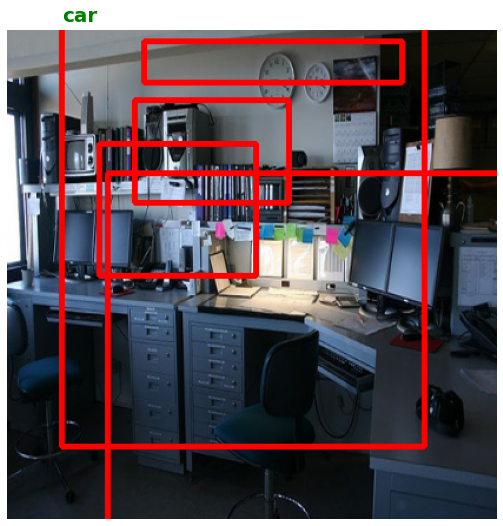

In [57]:
plt.figure(figsize=(9, 9))
gen.imshow(new_img)
plt.text(
    box[0], box[1], 
    str(classes[classes_[0]]), 
    fontsize=20, color="g", fontweight="bold",
)
plt.show()